# Monte Carlo race simulation

Loads the trained XGBoost lap-time model plus overtaking, DNF, and safety-car models, then runs repeated race simulations with aggregated results.

In [25]:
import os
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"]="1"

In [26]:

from pathlib import Path
import numpy as np
import pandas as pd
import joblib
import torch
from torch import nn


In [27]:
base_dir = Path.cwd()
if base_dir.name == 'models':
    base_dir = base_dir.parent
bundle_path = base_dir / 'models' / 'laptime_model_bundle.joblib'
if not bundle_path.exists():
    raise FileNotFoundError(f'Missing bundle at {bundle_path}')

# Load Option A bundle and dataset
bundle = joblib.load(bundle_path)

cat_vocabs = bundle["cat_vocabs"]
weather_scaler = bundle["weather_scaler"]
spline = bundle["spline"]
stint_stats = bundle["stint_stats"]
expected_global = float(bundle.get("expected_global", 15.0))
circuit_median_map = bundle.get("circuit_median_map", {})
global_median_lap = float(bundle.get("global_median_lap", 90.0))
driver_counts = bundle.get("driver_counts", {})
driver_shrink_k = float(bundle.get("driver_shrink_k", 2000.0))
track_cols = bundle.get("track_cols", [
    "track_temperature",
    "air_temperature",
    "humidity",
    "pressure",
    "wind_speed",
    "wind_direction",
])
weather_cols = bundle.get("weather_cols", track_cols + ["wet"])
clean_gap_threshold = float(bundle.get("clean_gap_threshold", 2.5))
noise_sigma_form = float(bundle.get("noise_sigma_form", 0.0))
noise_rho = float(bundle.get("noise_rho", 0.0))
noise_sigma_eta = float(bundle.get("noise_sigma_eta", 0.0))

print(f"Loaded laptime model bundle from {bundle_path}")
# Print noises
print(f"  noise_sigma_form: {noise_sigma_form}")
print(f"  noise_rho: {noise_rho}")
print(f"  noise_sigma_eta: {noise_sigma_eta}")

spline_cols = [f"lap_spline_{i}" for i in range(spline.n_features_out_)]
weather_scaled_cols = [c + "_scaled" for c in weather_cols]


def encode_series(series, vocab):
    return series.astype(str).map(lambda v: vocab.get(v, vocab["__UNK__"])).astype(int)


class CleanPaceModel(nn.Module):
    def __init__(self, vocab_sizes, spline_dim, weather_dim):
        super().__init__()
        self.driver_emb = nn.Embedding(vocab_sizes["driver"], 16)
        self.team_emb = nn.Embedding(vocab_sizes["team"], 8)
        self.circuit_emb = nn.Embedding(vocab_sizes["circuit"], 12)
        self.year_emb = nn.Embedding(vocab_sizes["year"], 4)
        self.session_emb = nn.Embedding(vocab_sizes["session"], 8)
        self.compound_emb = nn.Embedding(vocab_sizes["compound"], 4)

        base_in = 16 + 8 + 12 + 4 + 8
        self.base_linear = nn.Linear(base_in, 1)

        self.fuel_linear = nn.Linear(12, 1)
        self.track_linear = nn.Linear(8, spline_dim)

        tyre_in = 4 + 12 + weather_dim + 1
        self.tyre_mlp = nn.Sequential(
            nn.Linear(tyre_in, 32),
            nn.ReLU(),
            nn.Linear(32, 4),
        )

        self.weather_mlp = nn.Sequential(
            nn.Linear(weather_dim, 16),
            nn.ReLU(),
            nn.Linear(16, 1),
        )

        self.age_norm_weight = nn.Parameter(torch.tensor(0.0))
        self.age_over_weight = nn.Parameter(torch.tensor(0.0))
        self.bias = nn.Parameter(torch.zeros(1))

    def forward(self, batch):
        (
            driver_id, team_id, circuit_id, year_id, session_id, compound_id, driver_weight,
            laps_remaining_norm, tyre_age, age_norm, age_over_norm, expected_len, lap_spline, weather
        ) = batch

        driver_emb_raw = self.driver_emb(driver_id)
        unk_id = torch.zeros_like(driver_id)
        driver_emb_unk = self.driver_emb(unk_id)
        w = driver_weight.unsqueeze(1).clamp(0.0, 1.0)
        driver_emb = w * driver_emb_raw + (1.0 - w) * driver_emb_unk
        team_emb = self.team_emb(team_id)
        circuit_emb = self.circuit_emb(circuit_id)
        year_emb = self.year_emb(year_id)
        session_emb = self.session_emb(session_id)
        compound_emb = self.compound_emb(compound_id)

        base = self.base_linear(torch.cat([driver_emb, team_emb, circuit_emb, year_emb, session_emb], dim=1)).squeeze(1)

        fuel_k = torch.nn.functional.softplus(self.fuel_linear(circuit_emb).squeeze(1))
        fuel = fuel_k * laps_remaining_norm

        track_weights = self.track_linear(session_emb)
        track_evo = (lap_spline * track_weights).sum(dim=1)

        expected_len = torch.clamp(expected_len, min=1e-6)
        tyre_context = torch.cat([compound_emb, circuit_emb, weather, expected_len.unsqueeze(1)], dim=1)
        tyre_params = self.tyre_mlp(tyre_context)
        a = torch.nn.functional.softplus(tyre_params[:, 0])
        b = torch.nn.functional.softplus(tyre_params[:, 1])
        c = torch.nn.functional.softplus(tyre_params[:, 2])
        tau = torch.nn.functional.softplus(tyre_params[:, 3])
        age_term = a * tyre_age + b * (tyre_age ** 2)
        knee = torch.nn.functional.softplus(tyre_age - tau)
        tyre_deg = age_term + c * (knee ** 2)

        extra_age = torch.nn.functional.softplus(self.age_norm_weight) * age_norm
        extra_over = torch.nn.functional.softplus(self.age_over_weight) * age_over_norm

        weather_term = self.weather_mlp(weather).squeeze(1)

        pred = base + fuel + track_evo + tyre_deg + weather_term + extra_age + extra_over + self.bias
        return pred


class TrafficModel(nn.Module):
    def __init__(self, circuit_vocab_size):
        super().__init__()
        self.circuit_emb = nn.Embedding(circuit_vocab_size, 6)
        self.pmax_linear = nn.Linear(6, 1)
        self.g0_linear = nn.Linear(6, 1)
        self.s_raw = nn.Parameter(torch.tensor(0.5))
        self.drs_raw = nn.Parameter(torch.tensor(0.0))

    def forward(self, circuit_id, gap_ahead, drs):
        cemb = self.circuit_emb(circuit_id)
        pmax = torch.nn.functional.softplus(self.pmax_linear(cemb).squeeze(1))
        g0 = torch.nn.functional.softplus(self.g0_linear(cemb).squeeze(1))
        s = torch.nn.functional.softplus(self.s_raw) + 1e-3
        delta_drs = torch.sigmoid(self.drs_raw)
        penalty = pmax * torch.sigmoid((g0 - gap_ahead) / s)
        penalty = penalty * (1 - delta_drs * drs)
        return penalty


vocab_sizes = {
    "driver": len(cat_vocabs["driver_id"]) + 1,
    "team": len(cat_vocabs["team_id"]) + 1,
    "circuit": len(cat_vocabs["circuit_id"]) + 1,
    "year": len(cat_vocabs["year"]) + 1,
    "session": len(cat_vocabs["session_key"]) + 1,
    "compound": len(cat_vocabs["tyre_compound"]) + 1,
}

device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')

clean_model = CleanPaceModel(vocab_sizes, spline_dim=len(spline_cols), weather_dim=len(weather_scaled_cols)).to(device)
clean_model.load_state_dict(bundle["clean_model_state_dict"])
clean_model.eval()

traffic_model = TrafficModel(vocab_sizes["circuit"]).to(device)
traffic_model.load_state_dict(bundle["traffic_model_state_dict"])
traffic_model.eval()


# Load dataset for grid, team mapping, and defaults
csv_candidates = [Path("fastf1_lap_dataset.csv"), Path("models/fastf1_lap_dataset.csv")]
csv_path = next((p for p in csv_candidates if p.exists()), None)
if csv_path is None:
    raise FileNotFoundError("fastf1_lap_dataset.csv not found")

df = pd.read_csv(csv_path)

for col in ["safety_car_this_lap", "virtual_sc_this_lap"]:
    if col in df.columns:
        df[col] = df[col].fillna(False).astype(bool)
    else:
        df[col] = False

skill_df = df[(~df["safety_car_this_lap"]) & (~df["virtual_sc_this_lap"]) & df["lap_time_s"].notna()].copy()

session_stats = (
    skill_df
    .groupby("session_key")["lap_time_s"]
    .agg(session_median_lap="median", session_std_lap="std")
    .reset_index()
)

skill_df = skill_df.merge(session_stats, on="session_key", how="left")
skill_df["session_std_lap"] = skill_df["session_std_lap"].replace(0, np.nan)
skill_df["session_perf_z"] = -(
    skill_df["lap_time_s"] - skill_df["session_median_lap"]
) / skill_df["session_std_lap"]
skill_df["session_perf_z"] = skill_df["session_perf_z"].fillna(0.0)

driver_skill_raw = skill_df.groupby("driver_id")["session_perf_z"].mean()
driver_skill = (driver_skill_raw - driver_skill_raw.mean()) / driver_skill_raw.std()
driver_skill_map = driver_skill.fillna(0.0).to_dict()


def mode_or_first(series):
    if series.empty:
        return None
    modes = series.mode()
    if not modes.empty:
        return modes.iloc[0]
    return series.iloc[0]


driver_team_map = df.groupby("driver_id")["team_id"].apply(mode_or_first).to_dict()
team_by_year = (
    df.groupby(["year", "driver_id"])["team_id"].apply(mode_or_first).to_dict()
)
team_by_session = (
    df.groupby(["session_key", "driver_id"])["team_id"].apply(mode_or_first).to_dict()
)

session_key_map = (
    df
    .groupby(["circuit_id", "year"])["session_key"]
    .apply(mode_or_first)
    .to_dict()
)

default_session_key = mode_or_first(df["session_key"])
session_vocab = cat_vocabs["session_key"]
if default_session_key not in session_vocab:
    candidates = [k for k in session_vocab.keys() if k != "__UNK__"]
    default_session_key = candidates[0] if candidates else "__UNK__"

def lookup_session_key(circuit_id, year):
    key = session_key_map.get((circuit_id, year), default_session_key)
    if key not in session_vocab:
        key = default_session_key
    return key


weather_defaults = {}
for col in track_cols:
    if col in df.columns:
        weather_defaults[col] = float(pd.to_numeric(df[col], errors="coerce").median())
    else:
        weather_defaults[col] = 0.0

# Build a simple grid from the last session (order by first lap position)
last_session_key = df["session_key"].iloc[-1000]
grid_source = df[df["session_key"] == last_session_key]
first_lap_rows = grid_source[grid_source["lap_number"] == grid_source["lap_number"].min()]
grid_drivers = (
    first_lap_rows.sort_values("current_position")["driver_id"].drop_duplicates().tolist()
)
print(f"Grid built from session {last_session_key}: {grid_drivers}")

Loaded laptime model bundle from /Users/ekazuki/Documents/f1stuff/models/laptime_model_bundle.joblib
  noise_sigma_form: 1.2624231082287447
  noise_rho: 0.5811747348921247
  noise_sigma_eta: 4.25713754310131
Grid built from session 2025_united_states_grand_prix_race: ['VER', 'LEC', 'NOR', 'HAM', 'PIA', 'RUS', 'ANT', 'BEA', 'SAI', 'TSU', 'HUL', 'ALO', 'LAW', 'GAS', 'OCO', 'BOR', 'COL', 'STR', 'HAD', 'ALB']


In [28]:
cat_cols = ['driver_id', 'team_id', 'circuit_id', 'year', 'session_key', 'tyre_compound']

from pathlib import Path
# Initialize shared RNG and helper models
master_rng = np.random.default_rng(12345)

def _phase(progress):
    if progress < 0.33:
        return "early"
    if progress < 0.66:
        return "middle"
    return "late"

overtake_path = Path("models/overtaking_model.joblib")
if not overtake_path.exists():
    raise FileNotFoundError("Missing models/overtaking_model.joblib. Run models/overtaking_model.ipynb to train/export.")
overtake_bundle = joblib.load(overtake_path)
overtake_pipeline = overtake_bundle.get("pipeline")
overtake_include_year = bool(overtake_bundle.get("include_year", True))
overtake_gap_threshold = float(overtake_bundle.get("gap_threshold", 1.0))
overtake_base_rate = float(overtake_bundle.get("base_rate", 0.05))

def overtake_success_probability(attacker_state, defender_state, circuit_id, gap_start, year=None):
    if overtake_pipeline is None:
        return float(np.clip(overtake_base_rate, 0.01, 0.95))

    def _safe_num(value, default=0.0):
        if value is None or pd.isna(value):
            return default
        return float(value)

    skill_att = float(driver_skill_map.get(attacker_state.get("driver_id"), 0.0))
    skill_def = float(driver_skill_map.get(defender_state.get("driver_id"), 0.0))
    skill_diff = skill_att - skill_def

    att_laps = _safe_num(attacker_state.get("laps_on_current_tyre", 0.0), 0.0)
    def_laps = _safe_num(defender_state.get("laps_on_current_tyre", att_laps), att_laps)
    tyre_adv_laps = def_laps - att_laps

    gap_value = _safe_num(gap_start, overtake_gap_threshold)

    feature_row = {
        "circuit_id": str(circuit_id) if circuit_id is not None else "unknown",
        "gap_start": float(max(gap_value, 0.0)),
        "tyre_age_diff": float(tyre_adv_laps),
        "skill_diff": float(skill_diff),
    }
    if overtake_include_year:
        if year is None or pd.isna(year):
            year_value = "unknown"
        else:
            try:
                year_value = str(int(year))
            except (TypeError, ValueError):
                year_value = str(year)
        feature_row["year"] = year_value

    X = pd.DataFrame([feature_row])
    prob = float(overtake_pipeline.predict_proba(X)[0, 1])
    return float(np.clip(prob, 0.01, 0.95))

def apply_overtakes_for_lap(
    circuit_id,
    drivers_by_pos,
    lap_times,
    base_lap,
    year=None,
    close_gap_threshold=None,
    fail_gap=0.4,
    rng=None,
):
    """Apply overtaking effects to one lap prediction for ordered drivers."""
    lap_times = np.asarray(lap_times, dtype=float).copy()
    n = len(drivers_by_pos)

    overtake_attempts = np.zeros(n, dtype=bool)
    if close_gap_threshold is None:
        close_gap_threshold = overtake_gap_threshold

    rng = rng or master_rng

    for idx in range(1, n):
        follower = drivers_by_pos[idx]
        leader = drivers_by_pos[idx - 1]

        gap_start = float(follower["gap_to_ahead"])
        leader_time = lap_times[idx - 1]
        follower_time = lap_times[idx]
        gap_end_raw = gap_start + (follower_time - leader_time)

        going_to_pass_raw = gap_end_raw < 0.0
        close_enough = gap_start <= close_gap_threshold

        if not going_to_pass_raw and not close_enough:
            continue

        overtake_attempts[idx] = True

        margin = max(0.0, -gap_end_raw)
        p_success = overtake_success_probability(
            attacker_state=follower,
            defender_state=leader,
            circuit_id=circuit_id,
            gap_start=gap_start,
            year=year,
        )
        p_success = float(min(0.99, p_success + 0.15 * min(margin / 0.5, 1.0)))

        success = (rng.random() < p_success) and going_to_pass_raw
        if success:
            continue

        desired_follower_time = leader_time + fail_gap - gap_start
        if desired_follower_time > follower_time:
            lap_times[idx] = desired_follower_time

    pred_deltas = lap_times - float(base_lap)
    return lap_times, pred_deltas, overtake_attempts

dnf_path = Path("models/dnf_model.joblib")
if not dnf_path.exists():
    raise FileNotFoundError("Missing models/dnf_model.joblib. Run models/dnf_model.ipynb to train/export.")
dnf_bundle = joblib.load(dnf_path)
dnf_pipeline = dnf_bundle["pipeline"]
dnf_include_year = bool(dnf_bundle.get("include_year", True))
dnf_avg_total_laps = float(dnf_bundle.get("avg_total_laps", 50.0))

def dnf_hazard(circuit_id, lap_number, year=None, total_race_laps=None):
    total_laps = float(total_race_laps) if total_race_laps else float(dnf_avg_total_laps or 1.0)
    lap_num = float(lap_number or 0)
    progress = lap_num / total_laps if total_laps > 0 else 0.0

    data = {
        "circuit_id": str(circuit_id) if circuit_id is not None else "unknown",
        "lap_number": lap_num,
        "total_race_laps": total_laps,
        "progress": progress,
    }
    if dnf_include_year:
        data["year"] = str(year) if year is not None else "unknown"
    X = pd.DataFrame([data])
    prob = float(dnf_pipeline.predict_proba(X)[0, 1])
    return float(np.clip(prob, 1e-6, 0.5))

def apply_dnfs_for_lap(circuit_id, drivers_by_pos, lap_number, year=None, total_race_laps=None, rng=None):
    rng = rng or master_rng
    h = dnf_hazard(circuit_id, lap_number, year=year, total_race_laps=total_race_laps)
    dnfs_this_lap = []
    for driver in drivers_by_pos:
        if driver.get("dnf", False):
            dnfs_this_lap.append(False)
            continue
        dnf_now = bool(rng.random() < h)
        dnfs_this_lap.append(dnf_now)
        if dnf_now:
            driver["dnf"] = True
    return drivers_by_pos, dnfs_this_lap

safety_path = Path("models/safety_car_model.joblib")
if not safety_path.exists():
    raise FileNotFoundError("Missing models/safety_car_model.joblib. Run models/safety_car_model.ipynb to train/export.")
safety_bundle = joblib.load(safety_path)
safety_pipeline = safety_bundle["pipeline"]
safety_include_year = bool(safety_bundle.get("include_year", True))
safety_max_len_bucket = int(safety_bundle.get("max_len_bucket", 12))

def sc_transition_probs(state, stint_len, circuit_id, year, progress, lap_number):
    stint_bucket = 0 if state == "green" else min(int(stint_len), safety_max_len_bucket)
    phase = _phase(progress)
    row = {
        "state": state,
        "stint_bucket": float(stint_bucket),
        "race_progress": float(progress),
        "lap_number": float(lap_number),
        "circuit_id": str(circuit_id) if circuit_id is not None else "unknown",
        "phase": phase,
    }
    if safety_include_year:
        if year is None or pd.isna(year):
            year_value = "unknown"
        else:
            try:
                year_value = str(int(year))
            except (TypeError, ValueError):
                year_value = str(year)
        row["year"] = year_value
    else:
        row["year"] = "unknown"
    X = pd.DataFrame([row])
    probs = safety_pipeline.predict_proba(X)[0]
    class_map = dict(zip(safety_pipeline.classes_, probs))
    return {
        "green": float(class_map.get("green", 0.0)),
        "vsc": float(class_map.get("vsc", 0.0)),
        "sc": float(class_map.get("sc", 0.0)),
    }

def sc_next_state(state, stint_len, circuit_id, year, progress, lap_number, rng=None):
    rng = rng or master_rng
    probs = sc_transition_probs(state, stint_len, circuit_id, year, progress, lap_number)
    r = rng.random()
    if r < probs["green"]:
        next_state = "green"
    elif r < probs["green"] + probs["vsc"]:
        next_state = "vsc"
    else:
        next_state = "sc"

    if next_state == state and state in ("vsc", "sc"):
        next_len = int(stint_len) + 1
    elif next_state in ("vsc", "sc"):
        next_len = 1
    else:
        next_len = 0
    return next_state, next_len





In [29]:


def encode_value(value, vocab):
    return vocab.get(str(value), vocab["__UNK__"])


EXPECTED_STINT_MAP = {}
if 'expected_stint_len' in stint_stats.columns:
    EXPECTED_STINT_MAP = (
        stint_stats.set_index(["circuit_id", "tyre_compound"])["expected_stint_len"].to_dict()
    )


def predict_clean_and_traffic_fast(
    driver_id_ids,
    team_id_ids,
    circuit_id_ids,
    year_id_ids,
    session_id_ids,
    compound_ids,
    driver_weight,
    laps_remaining_norm,
    tyre_age,
    age_norm,
    age_over_norm,
    expected_len,
    lap_spline,
    weather_scaled,
    gap_ahead,
    drs,
):
    with torch.no_grad():
        features = [
            torch.tensor(driver_id_ids, dtype=torch.long, device=device),
            torch.tensor(team_id_ids, dtype=torch.long, device=device),
            torch.tensor(circuit_id_ids, dtype=torch.long, device=device),
            torch.tensor(year_id_ids, dtype=torch.long, device=device),
            torch.tensor(session_id_ids, dtype=torch.long, device=device),
            torch.tensor(compound_ids, dtype=torch.long, device=device),
            torch.tensor(driver_weight, dtype=torch.float32, device=device),
            torch.tensor(laps_remaining_norm, dtype=torch.float32, device=device),
            torch.tensor(tyre_age, dtype=torch.float32, device=device),
            torch.tensor(age_norm, dtype=torch.float32, device=device),
            torch.tensor(age_over_norm, dtype=torch.float32, device=device),
            torch.tensor(expected_len, dtype=torch.float32, device=device),
            torch.tensor(lap_spline, dtype=torch.float32, device=device),
            torch.tensor(weather_scaled, dtype=torch.float32, device=device),
        ]
        clean_pred = clean_model(features).detach().cpu().numpy()

        circuit_t = torch.tensor(circuit_id_ids, dtype=torch.long, device=device)
        gap_t = torch.tensor(gap_ahead, dtype=torch.float32, device=device)
        drs_t = torch.tensor(drs, dtype=torch.float32, device=device)
        traffic_pred = traffic_model(circuit_t, gap_t, drs_t).detach().cpu().numpy()

    return clean_pred, traffic_pred




def apply_overtakes_for_lap(
    circuit_id,
    drivers_by_pos,
    lap_times,
    base_lap,
    year=None,
    close_gap_threshold=None,
    fail_gap=0.3,
    rng=None,
):
    lap_times = np.asarray(lap_times, dtype=float).copy()
    base_lap = float(base_lap)
    n = len(drivers_by_pos)

    overtake_attempts = np.zeros(n, dtype=bool)
    if close_gap_threshold is None:
        close_gap_threshold = overtake_gap_threshold

    rng = rng or master_rng

    for idx in range(1, n):
        follower = drivers_by_pos[idx]
        leader = drivers_by_pos[idx - 1]

        gap_start = float(follower["gap_to_ahead"])
        leader_time = lap_times[idx - 1]
        follower_time = lap_times[idx]
        gap_end_raw = gap_start + (follower_time - leader_time)

        going_to_pass_raw = gap_end_raw < 0.0
        close_enough = gap_start <= close_gap_threshold

        if not going_to_pass_raw and not close_enough:
            continue

        overtake_attempts[idx] = True

        margin = max(0.0, -gap_end_raw)
        p_success = overtake_success_probability(
            attacker_state=follower,
            defender_state=leader,
            circuit_id=circuit_id,
            gap_start=gap_start,
            year=year,
        )
        p_success = float(min(0.99, p_success + 0.15 * min(margin / 0.5, 1.0)))

        success = (rng.random() < p_success) and going_to_pass_raw
        if success:
            continue

        desired_follower_time = leader_time + fail_gap - gap_start
        if desired_follower_time > follower_time:
            lap_times[idx] = desired_follower_time

    pred_deltas = lap_times - base_lap
    return lap_times, pred_deltas, overtake_attempts


def simulate_race(
    circuit_id,
    grid_drivers,
    total_laps=50,
    year=2025,
    global_strategy=None,
    driver_strategies=None,
    safety_car_laps=None,
    rain_laps=None,
    pit_loss=20.0,
    rng=None,
):
    # Simulate a race and return (race_log_df, safety_car_lap_set).

    rng = rng or np.random.default_rng()

    base_seed = int(rng.integers(0, 1_000_000_000))
    sc_rng = np.random.default_rng(base_seed + 2)
    overtake_rng = np.random.default_rng(base_seed + 3)
    dnf_rng = np.random.default_rng(base_seed + 4)
    pit_rng = np.random.default_rng(base_seed + 6)

    noise_by_driver = {}
    if noise_sigma_form > 0 or noise_sigma_eta > 0:
        noise_rng = np.random.default_rng(base_seed + 5)
        for drv in grid_drivers:
            form = float(noise_rng.normal(0.0, noise_sigma_form))
            eps = 0.0
            lap_noise = []
            for _ in range(total_laps):
                eps = noise_rho * eps + noise_rng.normal(0.0, noise_sigma_eta)
                lap_noise.append(form + eps)
            noise_by_driver[drv] = lap_noise

    if global_strategy is None:
        raise ValueError("global_strategy must be provided, e.g. [(20, 'MEDIUM'), (40, 'SOFT')]")
    if driver_strategies is None:
        driver_strategies = {}

    if safety_car_laps is None:
        auto_sc_laps = set()
        state, stint_len = 'green', 0
        for lap in range(1, total_laps + 1):
            if state == 'sc':
                auto_sc_laps.add(lap)
            progress = lap / total_laps
            state, stint_len = sc_next_state(state, stint_len, circuit_id, year, progress, lap, rng=sc_rng)
        safety_car_laps = auto_sc_laps
    else:
        safety_car_laps = set(safety_car_laps)

    if rain_laps is None:
        rain_laps = set()
    else:
        rain_laps = set(rain_laps)

    session_key = lookup_session_key(circuit_id, year)
    circuit_id_id = encode_value(circuit_id, cat_vocabs["circuit_id"])
    year_id = encode_value(year, cat_vocabs["year"])
    session_id = encode_value(session_key, cat_vocabs["session_key"])

    expected_by_compound = {
        comp: float(val)
        for (circuit, comp), val in EXPECTED_STINT_MAP.items()
        if circuit == circuit_id
    }
    compound_vocab = cat_vocabs["tyre_compound"]

    lap_progress = np.arange(1, total_laps + 1) / total_laps
    lap_progress_df = pd.DataFrame({"lap_progress": lap_progress})
    spline_by_lap = spline.transform(lap_progress_df)
    laps_remaining_norm_by_lap = (total_laps - np.arange(1, total_laps + 1)) / total_laps

    weather_vals = []
    for col in weather_cols:
        if col == "wet":
            weather_vals.append(0.0)
        else:
            weather_vals.append(weather_defaults.get(col, 0.0))
    weather_scaled_vec = weather_scaler.transform(pd.DataFrame([weather_vals], columns=weather_cols))[0]

    def lookup_team_id(driver_id):
        team_id = team_by_session.get((session_key, driver_id))
        if team_id is None:
            team_id = team_by_year.get((year, driver_id))
        if team_id is None:
            team_id = driver_team_map.get(driver_id)
        return team_id

    def resolve_strategy(strat, rng):
        stops_map = {}
        starting_tyre = None
        for item in strat:
            if len(item) == 2:
                lap, compound = item
                lap = int(lap)
                if lap == 0:
                    starting_tyre = compound
                else:
                    stops_map[lap] = compound
            elif len(item) == 3:
                start, end, compound = item
                start = int(start)
                end = int(end)
                if start > end:
                    start, end = end, start
                if start <= 0 <= end:
                    raise ValueError('Pit window cannot include lap 0; use (0, compound) for starting tyre')
                window_laps = [lap for lap in range(start, end + 1) if lap > 0 and lap <= total_laps]
                if not window_laps:
                    continue
                lap = int(rng.integers(window_laps[0], window_laps[-1] + 1))
                if lap in stops_map:
                    for candidate in window_laps:
                        if candidate not in stops_map:
                            lap = candidate
                            break
                stops_map[lap] = compound
            else:
                raise ValueError('Strategy entries must be (lap, compound) or (start, end, compound)')

        if starting_tyre is None:
            raise ValueError('Strategy must include lap 0 entry for starting tyre')
        return starting_tyre, stops_map

    grid_pos_map = {drv: idx + 1 for idx, drv in enumerate(grid_drivers)}

    drivers_state = []
    for idx, drv in enumerate(grid_drivers):
        strat = driver_strategies.get(drv, global_strategy)
        starting_tyre, stops_map = resolve_strategy(strat, pit_rng)
        drivers_state.append(
            {
                "driver_id": drv,
                "team_id": lookup_team_id(drv),
                "driver_id_id": encode_value(drv, cat_vocabs["driver_id"]),
                "team_id_id": encode_value(lookup_team_id(drv), cat_vocabs["team_id"]),
                "driver_weight": float(driver_counts.get(drv, 0.0)) / (float(driver_counts.get(drv, 0.0)) + driver_shrink_k),
                "grid_position": idx + 1,
                "position": idx + 1,
                "cumul_time": float(idx * 0.3),
                "laps_on_current_tyre": 1,
                "tyre_compound": starting_tyre,
                "gap_to_ahead": 0.0,
                "stops": stops_map,
                "history": [],
                "dnf": False,
            }
        )

    race_log = []

    for lap in range(1, total_laps + 1):
        prev_positions = {s["driver_id"]: s["position"] for s in drivers_state}
        drivers_by_pos = sorted(
            [s for s in drivers_state if not s.get("dnf", False)],
            key=lambda s: s["position"],
        )

        for idx, s in enumerate(drivers_by_pos):
            if idx == 0:
                s["gap_to_ahead"] = 0.0
            else:
                ahead = drivers_by_pos[idx - 1]
                s["gap_to_ahead"] = s["cumul_time"] - ahead["cumul_time"]

        n = len(drivers_by_pos)
        laps_on_tyre_for_update = []
        gap_ahead = np.zeros(n, dtype=float)
        drs = np.zeros(n, dtype=float)
        tyre_age = np.zeros(n, dtype=float)
        expected_len = np.zeros(n, dtype=float)
        compound_ids = np.zeros(n, dtype=int)
        driver_id_ids = np.zeros(n, dtype=int)
        team_id_ids = np.zeros(n, dtype=int)
        driver_weight = np.zeros(n, dtype=float)

        for idx, s in enumerate(drivers_by_pos):
            tyre_age_feature = s["laps_on_current_tyre"]
            laps_on_current_tyre_next = tyre_age_feature + 1
            gap_val = float(s["gap_to_ahead"])
            drs_enabled = 1 if (lap >= 3 and gap_val <= 1.0) else 0

            exp_len = expected_by_compound.get(s["tyre_compound"], expected_global)

            gap_ahead[idx] = gap_val
            drs[idx] = drs_enabled
            tyre_age[idx] = float(tyre_age_feature)
            expected_len[idx] = float(exp_len)
            compound_ids[idx] = compound_vocab.get(str(s["tyre_compound"]), compound_vocab["__UNK__"])
            driver_id_ids[idx] = s["driver_id_id"]
            team_id_ids[idx] = s["team_id_id"]
            driver_weight[idx] = s["driver_weight"]

            laps_on_tyre_for_update.append(laps_on_current_tyre_next)

        age_norm = tyre_age / np.maximum(expected_len, 1e-6)
        age_over = np.clip(tyre_age - expected_len, 0.0, None)
        age_over_norm = age_over / np.maximum(expected_len, 1e-6)

        lap_spline = np.tile(spline_by_lap[lap - 1], (n, 1))
        laps_remaining_norm = np.full(n, laps_remaining_norm_by_lap[lap - 1], dtype=float)
        weather_scaled = np.tile(weather_scaled_vec, (n, 1))
        circuit_id_ids = np.full(n, circuit_id_id, dtype=int)
        year_id_ids = np.full(n, year_id, dtype=int)
        session_id_ids = np.full(n, session_id, dtype=int)

        clean_pred, traffic_pred = predict_clean_and_traffic_fast(
            driver_id_ids,
            team_id_ids,
            circuit_id_ids,
            year_id_ids,
            session_id_ids,
            compound_ids,
            driver_weight,
            laps_remaining_norm,
            tyre_age,
            age_norm,
            age_over_norm,
            expected_len,
            lap_spline,
            weather_scaled,
            gap_ahead,
            drs,
        )
        clean_pred = np.asarray(clean_pred, dtype=float)
        traffic_pred = np.asarray(traffic_pred, dtype=float)
        base_lap = circuit_median_map.get(circuit_id, global_median_lap)
        lap_times = base_lap + clean_pred + traffic_pred

        safety_car_active = lap in safety_car_laps
        if safety_car_active:
            lap_times = np.asarray(lap_times, dtype=float)
            leader_time = lap_times[0] * 1.35
            sc_lap_times = [leader_time]
            for idx in range(1, len(drivers_by_pos)):
                candidate = float(lap_times[idx])
                start_gap = float(drivers_by_pos[idx]["gap_to_ahead"])
                gap_end = start_gap + (candidate - sc_lap_times[idx - 1])
                if gap_end < 0.0:
                    candidate = candidate + abs(gap_end) + 0.3
                sc_lap_times.append(candidate)
            lap_times = np.array(sc_lap_times)
            pred_deltas = lap_times - base_lap
            overtake_attempts = np.zeros(len(drivers_by_pos), dtype=bool)
        else:
            if noise_by_driver:
                lap_times = np.asarray(lap_times, dtype=float)
                for idx, s in enumerate(drivers_by_pos):
                    noise_seq = noise_by_driver.get(s["driver_id"])
                    if noise_seq is not None and lap - 1 < len(noise_seq):
                        lap_times[idx] += float(noise_seq[lap - 1])
            lap_times, pred_deltas, overtake_attempts = apply_overtakes_for_lap(
                circuit_id=circuit_id,
                drivers_by_pos=drivers_by_pos,
                lap_times=lap_times,
                base_lap=base_lap,
                year=year,
                close_gap_threshold=1.0,
                fail_gap=0.3,
                rng=overtake_rng,
            )

        drivers_by_pos, dnfs_this_lap = apply_dnfs_for_lap(
            circuit_id=circuit_id,
            drivers_by_pos=drivers_by_pos,
            lap_number=lap,
            total_race_laps=total_laps,
            year=year,
            rng=overtake_rng,
        )

        attempts_this_lap = {
            drivers_by_pos[i]["driver_id"]: bool(overtake_attempts[i])
            for i in range(len(drivers_by_pos))
        }
        dnfs_map_this_lap = {
            drivers_by_pos[i]["driver_id"]: bool(dnfs_this_lap[i])
            for i in range(len(drivers_by_pos))
        }

        for idx, s in enumerate(drivers_by_pos):
            lap_time = float(lap_times[idx])
            delta = float(pred_deltas[idx])
            laps_on_current_tyre_next = int(laps_on_tyre_for_update[idx])

            compound_this_lap = s["tyre_compound"]
            pit_compound = s["stops"].get(lap)
            pitted = False
            if pit_compound is not None:
                lap_time += pit_loss
                pitted = True

            dnf_now = dnfs_map_this_lap.get(s["driver_id"], False)
            s["dnf"] = bool(s.get("dnf", False) or dnf_now)

            if not s["dnf"]:
                s["laps_on_current_tyre"] = laps_on_current_tyre_next
                s["cumul_time"] += lap_time

            s["history"].append(
                {
                    "lap": lap,
                    "lap_time": lap_time if not dnf_now else None,
                    "delta": delta if not dnf_now else None,
                    "tyre_compound": compound_this_lap,
                    "pitted": pitted,
                    "overtake_attempt": attempts_this_lap.get(s["driver_id"], False),
                    "dnf": dnf_now,
                }
            )

            if s["dnf"]:
                continue
            if pit_compound is not None:
                s["tyre_compound"] = pit_compound
                s["laps_on_current_tyre"] = 1

        drivers_state = sorted(
            drivers_state,
            key=lambda s: (s.get("dnf", False), s["cumul_time"], s["grid_position"]),
        )
        for pos, s in enumerate(drivers_state, start=1):
            s["position"] = pos

        leader_time = drivers_state[0]["cumul_time"]
        for s in drivers_state:
            last_lap = s["history"][-1]
            gap_to_leader = s["cumul_time"] - leader_time
            pitted = last_lap["pitted"]
            attempted = last_lap["overtake_attempt"]
            dnf_now = last_lap.get("dnf", False)
            lap_time = last_lap["lap_time"]
            delta = last_lap["delta"]

            race_log.append(
                {
                    "lap": lap,
                    "position": s["position"],
                    "driver_id": s["driver_id"],
                    "lap_time": lap_time,
                    "delta": delta,
                    "tyre_compound": last_lap["tyre_compound"],
                    "pitted": pitted,
                    "gap_to_leader": gap_to_leader,
                    "cumul_time": s["cumul_time"],
                    "overtake_attempt": attempted,
                    "dnf": dnf_now or s.get("dnf", False),
                    "pos_change_lap": prev_positions[s["driver_id"]] - s["position"],
                    "pos_change_total": grid_pos_map[s["driver_id"]] - s["position"],
                    "safety_car": safety_car_active,
                }
            )

    return pd.DataFrame(race_log), safety_car_laps


# Single race monte carlo simulation

In [30]:
# Monte Carlo execution
num_runs = 20
race_length = 50
global_strategy = [(0, "SOFT"), (20, "MEDIUM"), (40, "SOFT")]
results = []
summary_rows = []
master_rng = np.random.default_rng(12315)
driver_strategies = {

}
circuits = df["circuit_id"].dropna().unique().tolist()
years_by_circuit = df.groupby("circuit_id")["year"].unique().to_dict()
for run in range(num_runs):
    run_rng = np.random.default_rng(master_rng.integers(0, 1_000_000_000))
    circuit_id = run_rng.choice(circuits)
    year = int(run_rng.choice(years_by_circuit.get(circuit_id, [2025])))
    race_log, sc_laps = simulate_race(
        circuit_id=circuit_id,
        grid_drivers=grid_drivers,
        total_laps=race_length,
        year=year,
        global_strategy=global_strategy,
        driver_strategies=driver_strategies,
        safety_car_laps=None,
        rain_laps=None,
        pit_loss=20.0,
        rng=run_rng,
    )
    race_log["run"] = run
    race_log["circuit_id"] = circuit_id
    race_log["year"] = year
    results.append(race_log)
    last_lap = race_log["lap"].max()
    final_class = race_log[race_log["lap"] == last_lap].sort_values("position")
    for _, row in final_class.iterrows():
        summary_rows.append(
            {
                "run": run,
                "circuit_id": circuit_id,
                "year": year,
                "driver_id": row["driver_id"],
                "finish_pos": row["position"],
                "dnf": bool(row["dnf"]),
                "sc_laps": len(sc_laps),
            }
        )
all_logs = pd.concat(results, ignore_index=True)
summary_df = pd.DataFrame(summary_rows)
# Aggregate overview
overview = (
    summary_df.groupby("driver_id")
    .agg(
        runs=("run", "nunique"),
        wins=("finish_pos", lambda s: (s == 1).sum()),
        podiums=("finish_pos", lambda s: (s <= 3).sum()),
        avg_finish=("finish_pos", "mean"),
        dnfs=("dnf", "sum"),
    )
    .sort_values(["wins", "podiums"], ascending=[False, False])
)
print("Overview per driver:\n", overview)
print("\nSample final classification from last run:\n", summary_df[summary_df["run"] == (num_runs - 1)].sort_values("finish_pos"))


Overview per driver:
            runs  wins  podiums  avg_finish  dnfs
driver_id                                       
VER          20     5        6        6.95     0
NOR          20     4        8        8.25     1
HUL          20     2        3        9.70     1
LEC          20     2        3       10.55     1
HAM          20     1        5        8.50     1
RUS          20     1        5        8.65     0
BOR          20     1        4        9.55     0
BEA          20     1        3       11.80     0
STR          20     1        3       10.85     0
ALB          20     1        2       10.50     0
COL          20     1        2       11.65     1
ANT          20     0        6        8.65     1
OCO          20     0        3       10.20     1
PIA          20     0        2        9.75     2
ALO          20     0        1       12.05     0
GAS          20     0        1       12.10     0
HAD          20     0        1       11.70     0
LAW          20     0        1       13.85     

# Compare two strategies with monte carlo


Progress: 120/2000
Wins per strategy: strategy
A    120
B    120
Name: driver_id, dtype: int64
Average finish per driver (A vs B, lower is better):


strategy,A,B,delta_B_minus_A,avg_lap_time_A,avg_lap_time_B,dnf_A,dnf_B,sc_laps_A,sc_laps_B
driver_id,,,,,,,,,
LEC,8.216667,7.791667,-0.425000,87.700001,87.481002,3,3,1.525157,1.525157
PIA,9.683333,9.466667,-0.216667,88.103256,88.075634,3,3,1.525157,1.525157
COL,11.625000,11.425000,-0.200000,88.727889,88.674314,3,3,1.525157,1.525157
ALO,10.991667,10.816667,-0.175000,88.584682,88.554085,4,4,1.525157,1.525157
RUS,8.808333,8.666667,-0.141667,87.718685,87.721492,6,6,1.525157,1.525157
NOR,9.650000,9.525000,-0.125000,88.047377,88.016508,2,2,1.525157,1.525157
SAI,8.666667,8.550000,-0.116667,87.626257,87.598355,6,6,1.525157,1.525157
LAW,13.008333,12.991667,-0.016667,89.191049,89.205242,4,4,1.525157,1.525157
GAS,10.508333,10.508333,0.000000,88.440234,88.398553,1,1,1.525157,1.525157


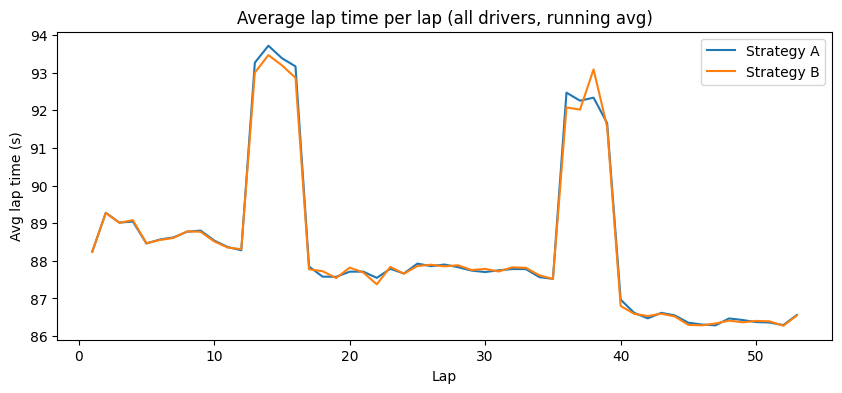

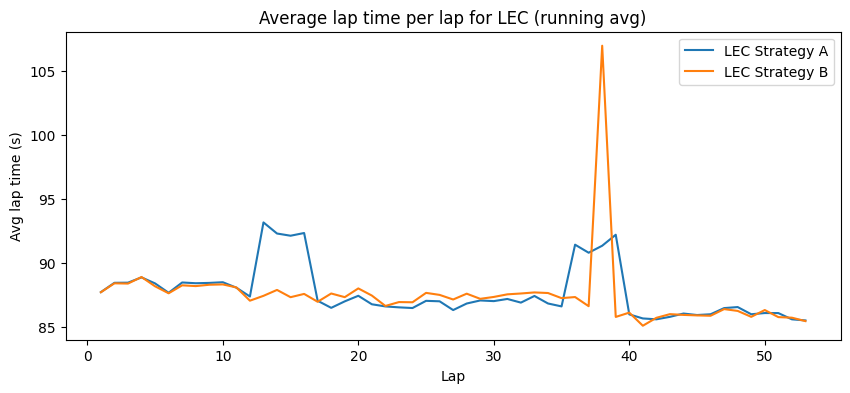

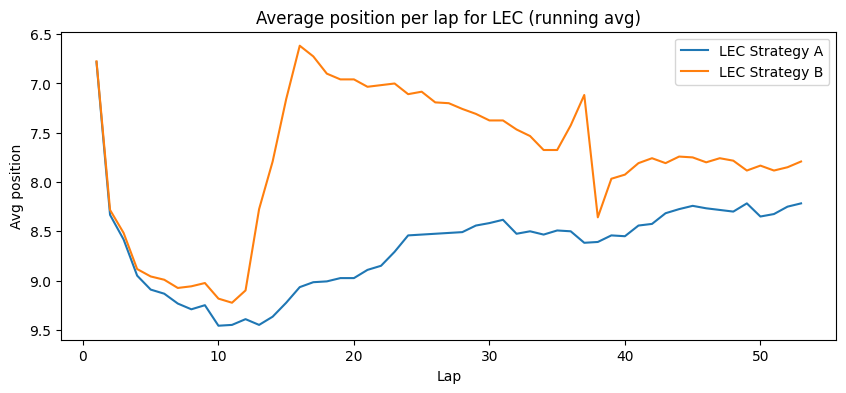

Strategy comparison:   7%|▋         | 137/2000 [03:16<44:35,  1.44s/it]


KeyboardInterrupt: 

In [32]:
# Strategy comparison (side-by-side Monte Carlo) with per-driver overrides
from IPython.display import display, clear_output
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

def run_strategy_comparison(
    strategy_a_global,
    strategy_b_global,
    strategy_a_driver,
    strategy_b_driver,
    num_runs_compare=2000,
    race_length=60,
    update_every=20,
    circuit_id=None,
    year=None,
    grid=None,
):
    summary_comp = []

    lap_sum = {"A": np.zeros(race_length), "B": np.zeros(race_length)}
    lap_count = {"A": np.zeros(race_length), "B": np.zeros(race_length)}

    driver_lap_sum = {"A": {}, "B": {}}
    driver_lap_count = {"A": {}, "B": {}}

    driver_pos_sum = {"A": {}, "B": {}}
    driver_pos_count = {"A": {}, "B": {}}

    def driver_avg_lap(label, drv):
        total = driver_lap_sum[label].get(drv, 0.0)
        count = driver_lap_count[label].get(drv, 0.0)
        return total / count if count else np.nan

    custom_drivers = {
        "A": list(strategy_a_driver.keys()),
        "B": list(strategy_b_driver.keys()),
    }

    all_custom_drivers = sorted(set(custom_drivers.get('A', []) + custom_drivers.get('B', [])))

    custom_sum = {
        label: {drv: np.zeros(race_length) for drv in all_custom_drivers}
        for label in ['A', 'B']
    }
    custom_count = {
        label: {drv: np.zeros(race_length) for drv in all_custom_drivers}
        for label in ['A', 'B']
    }

    for run in tqdm(range(num_runs_compare), desc="Strategy comparison"):
        run_rng = np.random.default_rng(master_rng.integers(0, 1_000_000_000))
        chosen_circuit = circuit_id if circuit_id is not None else run_rng.choice(circuits)
        chosen_year = int(year) if year is not None else int(run_rng.choice(years_by_circuit.get(chosen_circuit, [2025])))
        chosen_grid = grid if grid is not None else grid_drivers

        configs = [
            ('A', strategy_a_global, strategy_a_driver),
            ('B', strategy_b_global, strategy_b_driver),
        ]

        base_seed = run_rng.integers(0, 1_000_000_000)
        for label, glob_strat, driver_strats in configs:
            rng_run = np.random.default_rng(base_seed)
            race_log, sc_laps = simulate_race(
                circuit_id=chosen_circuit,
                grid_drivers=chosen_grid,
                total_laps=race_length,
                year=chosen_year,
                global_strategy=glob_strat,
                driver_strategies=driver_strats,
                safety_car_laps=None,
                rain_laps=None,
                pit_loss=20.0,
                rng=rng_run,
            )
            last_lap = race_log['lap'].max()
            final_class = race_log[race_log['lap'] == last_lap].sort_values('position')
            for _, row in final_class.iterrows():
                summary_comp.append({
                    'run': run,
                    'strategy': label,
                    'circuit_id': chosen_circuit,
                    'year': chosen_year,
                    'driver_id': row['driver_id'],
                    'finish_pos': row['position'],
                    'dnf': bool(row['dnf']),
                    'sc_laps': len(sc_laps),
                })

            lap_stats = (
                race_log
                .dropna(subset=['lap_time'])
                .groupby('lap')['lap_time']
                .agg(['sum', 'count'])
                .reindex(range(1, race_length + 1), fill_value=0.0)
            )
            lap_sum[label] += lap_stats['sum'].to_numpy()
            lap_count[label] += lap_stats['count'].to_numpy()

            driver_stats = (
                race_log
                .dropna(subset=['lap_time'])
                .groupby('driver_id')['lap_time']
                .agg(['sum', 'count'])
            )
            for drv, row in driver_stats.iterrows():
                driver_lap_sum[label][drv] = driver_lap_sum[label].get(drv, 0.0) + float(row['sum'])
                driver_lap_count[label][drv] = driver_lap_count[label].get(drv, 0.0) + float(row['count'])

            driver_pos_stats = (
                race_log
                .dropna(subset=['position'])
                .groupby(['driver_id', 'lap'])['position']
                .mean()
                .unstack(fill_value=np.nan)
                .reindex(columns=range(1, race_length + 1))
            )
            for drv in driver_pos_stats.index:
                pos_vals = driver_pos_stats.loc[drv].to_numpy(dtype=float)
                pos_sum = driver_pos_sum[label].get(drv)
                pos_cnt = driver_pos_count[label].get(drv)
                if pos_sum is None:
                    pos_sum = np.zeros(race_length)
                    pos_cnt = np.zeros(race_length)
                mask = ~np.isnan(pos_vals)
                pos_sum[mask] += pos_vals[mask]
                pos_cnt[mask] += 1
                driver_pos_sum[label][drv] = pos_sum
                driver_pos_count[label][drv] = pos_cnt

            for drv in all_custom_drivers:
                drv_stats = (
                    race_log[race_log['driver_id'] == drv]
                    .dropna(subset=['lap_time'])
                    .groupby('lap')['lap_time']
                    .agg(['sum', 'count'])
                    .reindex(range(1, race_length + 1), fill_value=0.0)
                )
                custom_sum[label][drv] += drv_stats['sum'].to_numpy()
                custom_count[label][drv] += drv_stats['count'].to_numpy()

        if (run + 1) % update_every == 0 or run == num_runs_compare - 1:
            summary_comp_df = pd.DataFrame(summary_comp)
            wins = summary_comp_df[summary_comp_df['finish_pos'] == 1].groupby('strategy')['driver_id'].count()
            avg_finish = summary_comp_df.groupby(['driver_id', 'strategy'])['finish_pos'].mean().unstack()
            avg_finish['delta_B_minus_A'] = avg_finish.get('B', np.nan) - avg_finish.get('A', np.nan)
            avg_finish['avg_lap_time_A'] = [driver_avg_lap('A', drv) for drv in avg_finish.index]
            avg_finish['avg_lap_time_B'] = [driver_avg_lap('B', drv) for drv in avg_finish.index]
            dnf_counts = summary_comp_df.groupby(['driver_id', 'strategy'])['dnf'].sum().unstack()
            avg_finish['dnf_A'] = dnf_counts.get('A')
            avg_finish['dnf_B'] = dnf_counts.get('B')
            sc_by_run = summary_comp_df[['run', 'strategy', 'sc_laps']].drop_duplicates()
            runs_a = sc_by_run[sc_by_run['strategy'] == 'A']['run'].nunique()
            runs_b = sc_by_run[sc_by_run['strategy'] == 'B']['run'].nunique()
            sc_pct_a = (sc_by_run[sc_by_run['strategy'] == 'A']['sc_laps'].sum() * 100.0 / max(runs_a * race_length, 1))
            sc_pct_b = (sc_by_run[sc_by_run['strategy'] == 'B']['sc_laps'].sum() * 100.0 / max(runs_b * race_length, 1))
            avg_finish['sc_laps_A'] = sc_pct_a
            avg_finish['sc_laps_B'] = sc_pct_b
            clear_output(wait=True)
            print(f"Progress: {run + 1}/{num_runs_compare}")
            print("Wins per strategy:", wins)
            print("Average finish per driver (A vs B, lower is better):")
            display(avg_finish.sort_values('delta_B_minus_A'))

            laps_axis = np.arange(1, race_length + 1)
            fig, ax = plt.subplots(figsize=(10, 4))
            for label, color in [('A', '#1f77b4'), ('B', '#ff7f0e')]:
                avg_lap = lap_sum[label] / np.maximum(lap_count[label], 1)
                ax.plot(laps_axis, avg_lap, label=f"Strategy {label}", color=color)
            ax.set_xlabel('Lap')
            ax.set_ylabel('Avg lap time (s)')
            ax.set_title('Average lap time per lap (all drivers, running avg)')
            ax.legend()
            plt.show()

            all_custom_drivers = sorted(set(custom_drivers.get('A', []) + custom_drivers.get('B', [])))
            for drv in all_custom_drivers:
                fig, ax = plt.subplots(figsize=(10, 4))
                plotted = False
                for label, color in [('A', '#1f77b4'), ('B', '#ff7f0e')]:
                    avg_driver = custom_sum[label].get(drv, np.zeros(race_length)) / np.maximum(custom_count[label].get(drv, np.zeros(race_length)), 1)
                    if np.any(custom_count[label].get(drv, np.zeros(race_length))):
                        ax.plot(laps_axis, avg_driver, label=f"{drv} Strategy {label}", color=color)
                    else:
                        ax.plot(laps_axis, avg_driver, label=f"{drv} Strategy {label}", color=color, alpha=0.25)
                    plotted = True
                if plotted:
                    ax.set_xlabel('Lap')
                    ax.set_ylabel('Avg lap time (s)')
                    ax.set_title(f"Average lap time per lap for {drv} (running avg)")
                    ax.legend()
                    plt.show()

            for drv in all_custom_drivers:
                fig, ax = plt.subplots(figsize=(10, 4))
                plotted = False
                for label, color in [('A', '#1f77b4'), ('B', '#ff7f0e')]:
                    pos_sum = driver_pos_sum.get(label, {}).get(drv, np.zeros(race_length))
                    pos_cnt = driver_pos_count.get(label, {}).get(drv, np.zeros(race_length))
                    avg_pos = pos_sum / np.maximum(pos_cnt, 1)
                    if np.any(pos_cnt):
                        ax.plot(laps_axis, avg_pos, label=f"{drv} Strategy {label}", color=color)
                    else:
                        ax.plot(laps_axis, avg_pos, label=f"{drv} Strategy {label}", color=color, alpha=0.25)
                    plotted = True
                if plotted:
                    ax.set_xlabel('Lap')
                    ax.set_ylabel('Avg position')
                    ax.set_title(f"Average position per lap for {drv} (running avg)")
                    ax.invert_yaxis()
                    ax.legend()
                    plt.show()

    summary_comp_df = pd.DataFrame(summary_comp)

    wins = summary_comp_df[summary_comp_df['finish_pos'] == 1].groupby('strategy')['driver_id'].count()
    avg_finish = summary_comp_df.groupby(['driver_id', 'strategy'])['finish_pos'].mean().unstack()
    avg_finish['delta_B_minus_A'] = avg_finish.get('B', np.nan) - avg_finish.get('A', np.nan)
    avg_finish['avg_lap_time_A'] = [driver_avg_lap('A', drv) for drv in avg_finish.index]
    avg_finish['avg_lap_time_B'] = [driver_avg_lap('B', drv) for drv in avg_finish.index]
    dnf_counts = summary_comp_df.groupby(['driver_id', 'strategy'])['dnf'].sum().unstack()
    avg_finish['dnf_A'] = dnf_counts.get('A')
    avg_finish['dnf_B'] = dnf_counts.get('B')
    sc_by_run = summary_comp_df[['run', 'strategy', 'sc_laps']].drop_duplicates()
    runs_a = sc_by_run[sc_by_run['strategy'] == 'A']['run'].nunique()
    runs_b = sc_by_run[sc_by_run['strategy'] == 'B']['run'].nunique()
    sc_pct_a = (sc_by_run[sc_by_run['strategy'] == 'A']['sc_laps'].sum() * 100.0 / max(runs_a * race_length, 1))
    sc_pct_b = (sc_by_run[sc_by_run['strategy'] == 'B']['sc_laps'].sum() * 100.0 / max(runs_b * race_length, 1))
    avg_finish['sc_laps_A'] = sc_pct_a
    avg_finish['sc_laps_B'] = sc_pct_b

    print('Wins per strategy:', wins)
    print('Average finish per driver (A vs B, lower is better): ', avg_finish.sort_values('delta_B_minus_A'))

    laps_axis = np.arange(1, race_length + 1)
    fig, ax = plt.subplots(figsize=(10, 4))
    for label, color in [('A', '#1f77b4'), ('B', '#ff7f0e')]:
        avg_lap = lap_sum[label] / np.maximum(lap_count[label], 1)
        ax.plot(laps_axis, avg_lap, label=f"Strategy {label}", color=color)
    ax.set_xlabel('Lap')
    ax.set_ylabel('Avg lap time (s)')
    ax.set_title('Average lap time per lap (all drivers, all runs)')
    ax.legend()
    plt.show()

    for label in ['A', 'B']:
        for drv in custom_drivers.get(label, []):
            avg_driver = custom_sum[label][drv] / np.maximum(custom_count[label][drv], 1)
            fig, ax = plt.subplots(figsize=(10, 4))
            ax.plot(laps_axis, avg_driver, label=f"{drv} Strategy {label}")
            ax.set_xlabel('Lap')
            ax.set_ylabel('Avg lap time (s)')
            ax.set_title(f"Average lap time per lap for {drv} (Strategy {label})")
            ax.legend()
            plt.show()

    return summary_comp_df, avg_finish

strategy_a_global = [(0, 'SOFT'), (13, 16, 'MEDIUM'), (36, 39, 'MEDIUM')]
strategy_b_global = [(0, 'SOFT'), (13, 16, 'MEDIUM'), (36, 39, 'MEDIUM')]
# Optional per-driver overrides; leave empty to fall back to global strategy
strategy_a_driver = {}
strategy_b_driver = {
    "LEC": [(0, 'HARD'), (38, 'MEDIUM')],
}

num_runs_compare = 2000
race_length = 53
update_every = 20

summary_comp_df, avg_finish = run_strategy_comparison(
    strategy_a_global=strategy_a_global,
    strategy_b_global=strategy_b_global,
    strategy_a_driver=strategy_a_driver,
    strategy_b_driver=strategy_b_driver,
    num_runs_compare=num_runs_compare,
    race_length=race_length,
    update_every=update_every,
    year=2023,
    grid=None,
    circuit_id="monza"
)


MEDIUM -> SOFT -> -0.863158